# hysteresis_demo.ipynb
The purpose of this notebook is to demonstrate the creation of magnetic hysteresis models & their use in computing hysteresis quantities. If you need to install *rsradia*, uncomment the first line before running the cell below.

In [1]:
#%pip install git+https://github.com/radiasoft/rsradia.git

from numpy import array, zeros, load as npload
from matplotlib import pyplot as plt
from rsradia.hysteresis import JilesAtherton, Preisach

## Constructing hysteresis models with *rsradia*
All hysteresis models in *rsradia* derive from a ```HysteresisModel``` class and require a field step-size ```dH``` and optional choice of field ```units``` (default: ```SI```). ```units``` must be one of: ```SI``` (A m$^{-1}$); ```mm``` (A mm$^{-1}$); ```Tesla``` (T); or ```Gauss``` (G). Parameters with field units (including ```dH```) are assumed to be in ```units```.

### Jiles-Atherton Models
We create a Jiles-Atherton model for grade 20 steel in the cell below by defining a dictionary (```ja_params```) of physical parameters for the model and a choice of ```integrator``` for solving the Jiles-Atherton differential equation (see *How it Works* below). The physical parameters of the model are:

* ```alpha```: Domain coupling strength
* ```a```: Domain wall magnetization density  (in ```units```)
* ```Ms```: Saturation magnetization of material (in ```units```)
* ```k```: Pinning site breaking energy (in ```units```)
* ```c```: Magnetization reversability
* ```wa (0)```: Relative weight of anisotropic contributions to magnetization
* ```Ka (0)```: Average anisotropy energy density (in J m$^{-3}$)
* ```psi (0)```: Angle between anisotropy easy axis & magnetizing field

The ```integrator``` argument must be one of: ```EULER``` (simple Euler); ```RK4``` (4th order Runge-Kutta); or ```RK45``` (4th/5th order Runge-Kutta).

Parameters can be set to obtain models for both isotropic and anisotropic materials. If the parameters for either the relative anisotropy contribution (```wa```) or the average anisotropy energy density (```Ka```) are not set or are set to 0, an isotropic model will be used.

In [2]:
# Set Jiles-Atherton model parameters for low-carbon steel
ja_params = {
    'units' : 'SI',
    'dH' : 10,
    'sat_tol': 2.5e-4,
    
    'alpha': 4.93e-4,
    'a': 399,
    'Ms': 1.35e6,
    'k': 300,
    'c': 0.120,
    'wa': 0,
    'Ka': 0,
    'psi': 0,
    
    'integrator' : 'RK45',
}

# Construct the Jiles-Atherton hysteresis model
ja_model = JilesAtherton(**ja_params)

# Note: Once parameters have been passed, a model can be stored using the 'save'
# method. A stored model can be initialized in-context using the 'load' method.

#ja_model.save("path_to_model_storage")
# stored_model = JilesAtherton.load("path_to_stored_model")

### Preisach Models
We create a Preisach model for grade 20 steel in the cell below by providing physical parameters of the model and a choice of Presiech density ```distribution``` using a dictionary ```pr_params```. The physical parameters of the Preisach model are:

* ```Ms```: Saturation magnetization (in ```units```)
* ```ab_max```: Maximum hysteron field value (in ```units```)
* ```ab_res```: Grid spacing of hysteron field values (in ```units```)

The ```distribution``` and associated ```dist_params``` argument define the hysteron weight density over a grid (see *How it Works* below). The ```distribution``` argument must be one of: ```UNIFORM``` (uniform distribution); ```GAUSSIAN``` (normal distribution); ```GMIXTURE``` (Gaussian mixture); or a custom density given by a 2D *numpy* array. The ```dist_params``` argument depends on the type of ```distribution```: ```UNIFORM``` and custom distributions require no parameters (though custom distribution dimensions must match chosen values for ```ab_max``` and ```ab_res```); ```GAUSSIAN```distributions require a *2x1* mean vector & *2x2* covariance matrix; and ```GMIXTURE```distributions require a number of mixands *N* and lists of mean vectors, covariance matrices, & weights for each mixand.

In [3]:
# Define initial parameters for the Preisach density
pr_mus = array([[.08,-.08], [0,.3], [-.3,0], [-.55,-.65], [.65,.55]])
pr_Sigmas = array([[[.02,.0001],[.0001,.02]], [[.003,0],[0,.04]], [[.04,0],[0,.003]], \
                   [[.06,.045],[.045,.06]], [[.06,.045],[.045,.06]]])
pr_ws = array([.92, .01, .01, .03, .03])

# Set model parameters for grade 20 steel
pr_params = {
    'units' : 'SI',
    'dH': 10,
    
    'Ms': 1.25e6,
    'ab_max': 5e3,
    'ab_res': 25,
    
    'distribution': 'gmixture',
    'dist_params': (pr_mus, pr_Sigmas, pr_ws),
}

# Construct a Preisach model & compute its hysteresis
pr_model = Preisach(**pr_params)

# Note: Once parameters have been passed, a model can be stored using the 'save'
# method. A stored model can be initialized in-context using the 'load' method.

# pr_model.save("path_to_model_storage")
# stored_model = Preisach.load("path_to_stored_model")

## Using *rsradia* hysteresis models


Once a hysteresis model has been constructed (or loaded), it already contains a definition for the major hyseresis loop stored in the class members ```H_major``` and ```M_major```. This information can then be used to compute additional hysteresis quantities as the need arises.

As an example, the next cells will use both of the models created above to compute hysteresis quantities for the following use cases:
* Computing a minor hysteresis loop reaching 1/5 of the saturation field
* Computing a portion of the major hysteresis loop, beginning at a turnaround point
* Computing an interpolated magnetic flux density at an arbitrary, prescribed point
* Computing a portion of the major hysteresis loop beginning at a prescribed point

In [4]:
ja_model.convert_units("Tesla")
JaH_max = max(ja_model.H_major)
JaM_max = max(ja_model.M_major)

# Use the Jiles-Atherton model to compute hysteresis along a minor loop
ja_minor_path = [[0, JaH_max/5], [JaH_max/5, -JaH_max/5], [-JaH_max/5, JaH_max/5]]
JaH_minor, JaM_minor = ja_model.path(ja_minor_path, 1e-6)

# Use the Jiles-Atherton model to compute hysteresis along a portion of the major loop
ja_partial_path = [[JaH_max, 0]]
JaH_partial, JaM_partial = ja_model.path(ja_partial_path, JaM_max)

# Use the Jiles-Atherton model to compute magnetic flux density for an arbitrary applied field
JaH_point = -2.05e-3 #-1050.8
JaM_point_upper = ja_model.point(JaH_point, 'upper')

# Use a magnetic flux density at a prescribed applied field to compute hysteresis along a path
Ja_point_path = [[.5*JaH_point, 0]]
JaM_point_lower = ja_model.point(.5*JaH_point, 'lower')
JaH_point_path, JaM_point_path = ja_model.path(Ja_point_path, JaM_point_lower)

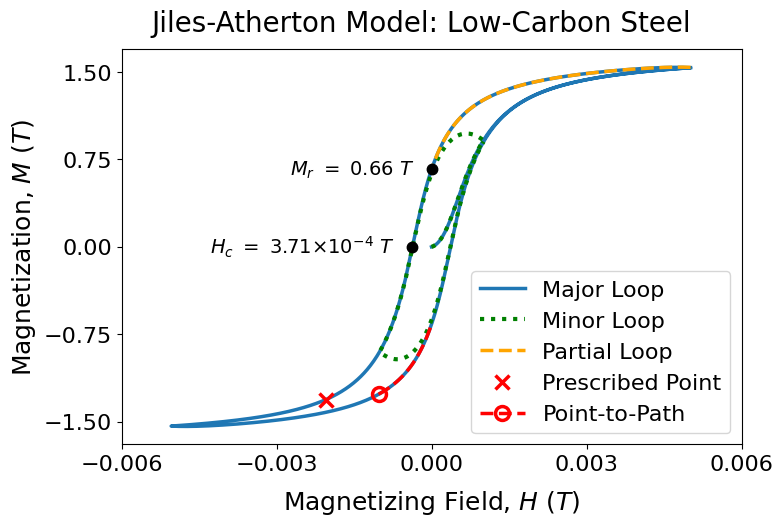

In [5]:
# Define tick values for plotting
H_ticks = [-6e-3, -3e-3, 0, 3e-3, 6e-3]
M_ticks = [-1.5, -.75, 0, .75, 1.5]
JaHc = ja_model.coercivity[1]
JaMr = ja_model.remanence[0]

# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Jiles-Atherton Model: Low-Carbon Steel",fontsize=20,y=.98)
ax.plot(ja_model.H_major, ja_model.M_major,lw=2.5,label=r"Major Loop")
ax.plot(JaH_minor, JaM_minor, ':', color='g', lw=3, label=r"Minor Loop")
ax.plot(JaH_partial, JaM_partial, '--', color='orange', lw=2.5, label=r"Partial Loop")
ax.plot(JaH_point, JaM_point_upper, 'x', color='red', ms=10, mew=2.5, label=r"Prescribed Point")
ax.plot(JaH_point_path, JaM_point_path, 'r--', lw=2.5, marker='o', mfc='none', ms=10, mew=2.5, markevery=[0], label=r"Point-to-Path")
ax.plot(JaHc, 0, 'ko', ms=7.5)
ax.text(JaHc-JaH_max/15, 0, r"$H_c\ =\ $"+r"{:.2f}".format(abs(JaHc)/1e-4)+r"$\times10^{-4}\ T$", ha='right', va='center', fontsize=14)
ax.plot(0, JaMr, 'ko', ms=7.5)
ax.text(-JaH_max/15, JaMr, r"$M_r\ =\ {:.2f}\ T$".format(JaMr), ha='right', va='center', fontsize=14)
ax.legend(fontsize=16, loc='lower right')
ax.axis(1.1*array([min(ja_model.H_major), max(ja_model.H_major), min(ja_model.M_major), max(ja_model.M_major)]))
ax.set_xlabel(r"Magnetizing Field, $H\ (T)$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Magnetization, $M\ (T)$",fontsize=18)
ax.set_xticks(H_ticks)
ax.set_yticks(M_ticks)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

### Preisach

In [6]:
pr_model.convert_units("Tesla")
PrH_max = max(pr_model.H_major)
PrM_max = max(pr_model.M_major)

# Use the Preisach model to compute hysteresis along a minor loop
Pr_minor_path = [[0, PrH_max/5], [PrH_max/5, -PrH_max/5], [-PrH_max/5, PrH_max/5]]
PrH_minor, PrM_minor = pr_model.path(Pr_minor_path, 0)

# Use the Preisach model to compute hysteresis along a portion of the major loop
PrH_partial, PrM_partial = pr_model.path([[PrH_max, 0]], PrM_max)

# Use the Preisach model to compute magnetic flux density for an arbitrary applied field
PrH_point = -2.05e-3 #-1050.8
PrM_point_upper = pr_model.point(PrH_point, 'upper')

# Use a magnetic flux density at a prescribed applied field to compute hysteresis along a path
Pr_point_path = [[.5*PrH_point, 0]]
PrM_point_lower = pr_model.point(.5*PrH_point, 'lower')
PrH_point_path, PrM_point_path = pr_model.path(Pr_point_path, PrM_point_lower)

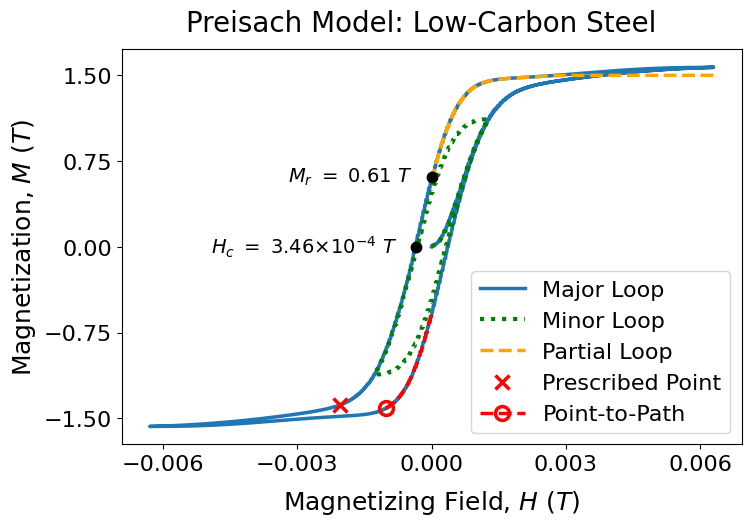

In [7]:
# Define tick values for plotting
H_ticks = [-6e-3, -3e-3, 0, 6e-3, 3e-3]
M_ticks = [-1.5, -.75, 0, .75, 1.5]
PrHc = pr_model.coercivity[1]
PrMr = pr_model.remanence[0]

# Plot the example hysteresis quantities for the Preisach model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Preisach Model: Low-Carbon Steel",fontsize=20,y=.98)
ax.plot(pr_model.H_major, pr_model.M_major,lw=2.5,label=r"Major Loop")
ax.plot(PrH_minor, PrM_minor, ':', color='g', lw=3, label=r"Minor Loop")
ax.plot(PrH_partial, PrM_partial, '--', color='orange', lw=2.5, label=r"Partial Loop")
ax.plot(PrH_point, PrM_point_upper, 'x', color='red', ms=10, mew=2.5, label=r"Prescribed Point")
ax.plot(PrH_point_path, PrM_point_path, 'r--', lw=2.5, marker='o', mfc='none', ms=10, mew=2.5, markevery=[0], label=r"Point-to-Path")
ax.plot(PrHc, 0, 'ko', ms=7.5)
ax.text(PrHc-PrH_max/15, 0, r"$H_c\ =\ $"+r"{:.2f}".format(abs(PrHc)/1e-4)+r"$\times10^{-4}\ T$", ha='right', va='center', fontsize=14)
ax.plot(0, PrMr, 'ko', ms=7.5)
ax.text(-PrH_max/15, PrMr, r"$M_r\ =\ {:.2f}\ T$".format(PrMr), ha='right', va='center', fontsize=14)
ax.legend(fontsize=16, loc='lower right')
ax.axis(1.1*array([min(pr_model.H_major), max(pr_model.H_major), min(pr_model.M_major), max(pr_model.M_major)]))
ax.set_xlabel(r"Magnetizing Field, $H\ (T)$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Magnetization, $M\ (T)$",fontsize=18)
ax.set_xticks(H_ticks)
ax.set_yticks(M_ticks)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

## How It Works

### Jiles-Atherton
The *rsradia* implementation of the Jiles-Atherton model functions by numerically integrating the differential equation from Jiles & Atherton (1984):

$\frac{dM}{dH} = \frac{1}{1+c}\frac{M_\text{an}-M}{\delta k - \alpha (M_\text{an} - M)} + \frac{c}{1+c} \frac{dM_\text{an}}{dH}$

where $M$ and $M_\text{an}$ are the total and anhysteretic magnetization, $H$ is the applied field, $\delta$ is the sign of changes in the applied field, and all other symbols are Jiles-Atherton parameters. This implementation includes the corrected anisotropic extension developed in Ramesh et al (1996) and Szewczyk (2014) so that:

$M_\text{an} = (1-w_\text{an}) M_\text{an}^\text{iso} + w_\text{an} M_\text{an}^\text{aniso}\qquad\text{and}\qquad\frac{dM_\text{an}}{dH}=(1-w_\text{an}) \frac{dM_\text{an}^\text{iso}}{dH} + w_\text{an} \frac{dM_\text{an}^\text{aniso}}{dH}$

where $w_\mathrm{an}$ is the relative weight of anisotropic effects and $M_\text{an}^\text{iso}$ and $M_\text{an}^\text{aniso}$ are the isotropic and anisotropic anhysteretic magnetization. The isotropic contributions to anhysteretic magnetization and its derivative are given analytically by:

$M_\text{an}^\text{iso} = M_s \left(\text{coth}\left(\frac{H_e}{a}\right)-\frac{a}{H_e}\right) \qquad\text{and}\qquad \frac{dM_\text{an}^\text{iso}}{dH}=M_s\left(\frac{a}{H_e^2}-\text{csch}^2\left(\frac{H_e}{a}\right)\right)$

The anisotropic contribution to anhysteretic magnetization is given by:

$M_\text{an}^\text{aniso} = M_s \frac{\int_0^\pi e^{0.5\left(E_1+E_2\right)}\text{sin}\left(\theta\right)\text{cos}\left(\theta\right)d\theta}{\int_0^\pi e^{0.5\left(E_1+E_2\right)}\text{sin}\left(\theta\right)d\theta}$

where

$E_1=\frac{H_e}{a}\text{cos}\left(\theta\right)-\frac{K_{an}}{\mu_0aM_s}\text{sin}^2\left(\psi-\theta\right) \qquad\text{and}\qquad E_2=\frac{H_e}{a}\text{cos}\left(\theta\right)-\frac{K_{an}}{\mu_0aM_s}\text{sin}^2\left(\psi+\theta\right)$

Since there is no closed-form expression for the derivative of $M_\text{an}^\text{aniso}$, it is aproximated by:

$\frac{dM_\text{an}^\text{aniso}}{dH}=\frac{M_\text{an}^\text{aniso}\left(H+\Delta H\right)-M_\text{an}^\text{aniso}\left(H-\Delta H\right)}{2\Delta H}$

### Preisach

Unlike Jiles-Atherton, the Preisach model does not involve integrating differential equations. Instead, it uses a grid method in which a weighted average is taken over a series of simple relays called hysterons. Each hysteron features a "switch-low" ($\alpha$) and "switch-high" ($\beta$) applied field value, and remains in its most recent low/high state for field values in between. The cell below plots the output of a single hysteron with ($\alpha$, $\beta$)=(-2000, 2000) for a range of applied fields.

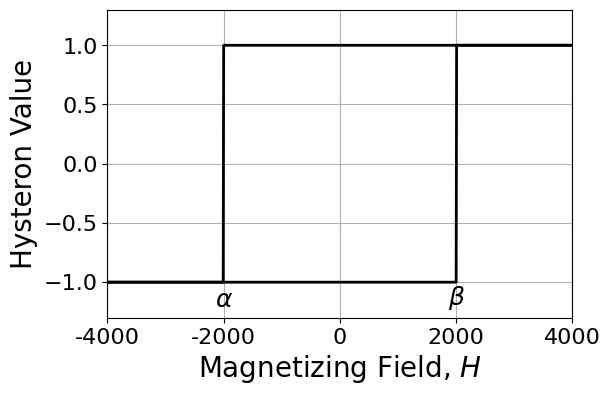

In [8]:
Bs = -4000 + array(range(1000))*8
alpha = -2000
beta = 2000
rho_up = 1 - 2 *(Bs<alpha)
rho_down = -1 + 2*(Bs>beta)

H_ticks = [-4000, -2000, 0, 2000, 4000]
B_ticks = [-1, -.5, 0, .5, 1.]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Bs, rho_up, 'k-', lw=2)
ax.plot(Bs, rho_down, 'k-', lw=2)
ax.text(alpha, -1.25, r"$\alpha$", fontsize=18, ha='center', va='bottom')
ax.text(beta, -1.25, r"$\beta$", fontsize=18, ha='center', va='bottom')
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=20)
ax.set_ylabel(r"Hysteron Value",fontsize=20)
ax.set_xticks(H_ticks)
ax.set_xticklabels(["-4000", r"-2000", "0", r"2000", "4000"])
ax.set_yticks(B_ticks)
ax.axis([-4000, 4000, -1.3, 1.3])
ax.tick_params(labelsize=16)
plt.grid()
fig.show()

By defining a series of these hysterons $R_{\alpha,\beta}$ with switching values covering the saturation range of a material, a weighted sum can be carried out which determines the overall magnetization of the material according to:

$M(H)=M_s\sum\limits_{\beta}\sum\limits_{\alpha<\beta}\mu_{\alpha,\beta}R_{\alpha,\beta}(H)$

where $\mu_{\alpha, \beta}$ are elements of the hysteron weight distribution, and $R_{\alpha, \beta}(H)$ are the values of individual hysterons. Since the switch-on field value must be higher than the switch-off value, only hysterons for which $\alpha<\beta$ are physical and need to be considered. The Preisach model is therefore parameterized entirely by the chosen grid of possible hysteron switching values and the weights assigned to each point on the grid.

The ```distribution``` and```dist_params``` arguments used to create a Preisach model above define a grid of ($\alpha$, $\beta$ ) values and the $\mu_{\alpha, \beta}$ at each location on the grid (this is why a custom distribution must have shape (*N+1*, *N+1*) where *N* is ```2*ab_max/ab_res``` rounded to the nearest whole number). During hysteresis calculations, $R_{\alpha,\beta}$ is defined over the grid in response to the applied field $H$. The cell below plots $\mu_{\alpha, \beta}$ and $R_{\alpha,\beta}$ for a given *H-M* pair.

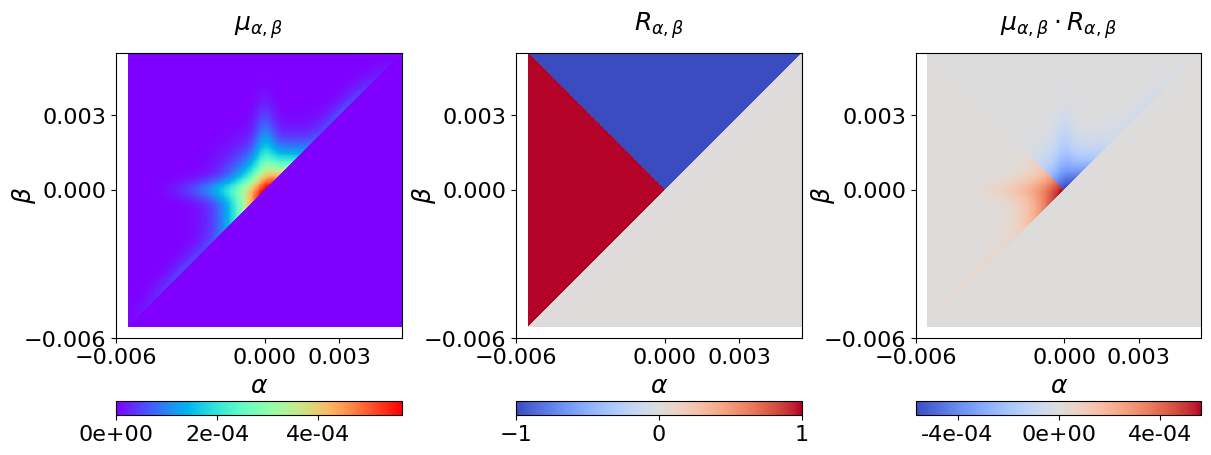

In [18]:
# Choose example values for magnetizing field and initial magnetization
H_ex = 0
M_ex = 0 #pr_model.remanence[0]

# Compute hysteron values at the prescribed field strength
R = pr_model._get_grid(M_ex)
R[pr_model._ab_grid[:,0]>=pr_model._ab_grid[:,1]] = 0

n_grid = int(len(pr_model._ab_grid)**.5)
imKwargs = {
    'origin': 'lower',
    'interpolation': 'none',
    'extent': 2*[1.1*pr_model._ab_grid.min(), 1.1*pr_model._ab_grid.max()],
}

fig, axs = plt.subplots(1, 3, figsize=(14,11))
axs[0].set_title(r"$\mu_{\alpha, \beta}$", fontweight='bold', fontsize='18', y=1.05)
axs[1].set_title(r"$R_{\alpha, \beta}$", fontweight='bold', fontsize='18', y=1.05)
axs[2].set_title(r"$\mu_{\alpha, \beta}\cdot R_{\alpha, \beta}$", fontweight='bold', fontsize='18', y=1.05)
dist = axs[0].imshow(pr_model._density.reshape(n_grid, n_grid).T, cmap='rainbow', **imKwargs)
cbar1 = fig.colorbar(dist, ax=axs[0], location="bottom", orientation="horizontal", format='%.0e')
cbar1.ax.tick_params(labelsize=16)
cbar1.ax.xaxis.offsetText.set_fontsize(16)
pgrid = axs[1].imshow(R.reshape(n_grid, n_grid).T, cmap='coolwarm', **imKwargs)
cbar2 = fig.colorbar(pgrid, ax=axs[1], location="bottom", orientation="horizontal")
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.xaxis.offsetText.set_fontsize(16)
cbar2.ax.set_xticks([-1, 0, 1])
wgrid = axs[2].imshow((R*pr_model._density).reshape(n_grid, n_grid).T, vmin=-pr_model._density.max(), vmax=pr_model._density.max(), cmap='coolwarm', **imKwargs)
cbar3 = fig.colorbar(wgrid, ax=axs[2], location="bottom", orientation="horizontal", format='%.0e')
cbar3.ax.tick_params(labelsize=16)
cbar3.ax.xaxis.offsetText.set_fontsize(16)
cbar3.ax.set_xticks([-4e-4, 0, 4e-4])
for ax in axs:
    ax.set_xlabel(r"$\alpha$",fontsize=18)
    ax.set_ylabel(r"$\beta$",fontsize=18, labelpad=-10)
    ax.tick_params(labelsize=16)
    ax.set_xticks(H_ticks[::2])
    ax.set_yticks(H_ticks[::2])
fig.subplots_adjust(wspace=.4, bottom=.5)
fig.show()

#### Describing uncommon dynamics
Although Jiles-Atherton is faster and sufficient for almost any relatively homogeneous, bulk magnetic material, there are some cases in which the Preisach model may be preferable. Especially in macrosopic, heterogeneous materials, complex dynamics can lead to "abnormal" hysteretic behaviors like bimodality. The cell below demonstrates how the extreme robustness of the Preisach model may be useful in reproducing such strange hysteretic features.

In [10]:
# Define parameters for the Preisach density
bimodal_mus = array([[-.8,-.1], [.1,.8]])
bimodal_Sigmas = array([[[.01,.0],[.0,.05]], [[.01,0],[0,.01]]])
bimodal_ws = array([.5, .5])

# Set model parameters for grade 20 steel
bimodal_params = {
    'dH': 10,
    
    'Ms': 1.2e6,
    'ab_max': 4e3,
    'ab_res': 50,
    'distribution': 'gmixture',
    'dist_params': (bimodal_mus, bimodal_Sigmas, bimodal_ws)
}

# Construct a Preisach model & compute its hysteresis
pr_bimodal = Preisach(**bimodal_params)

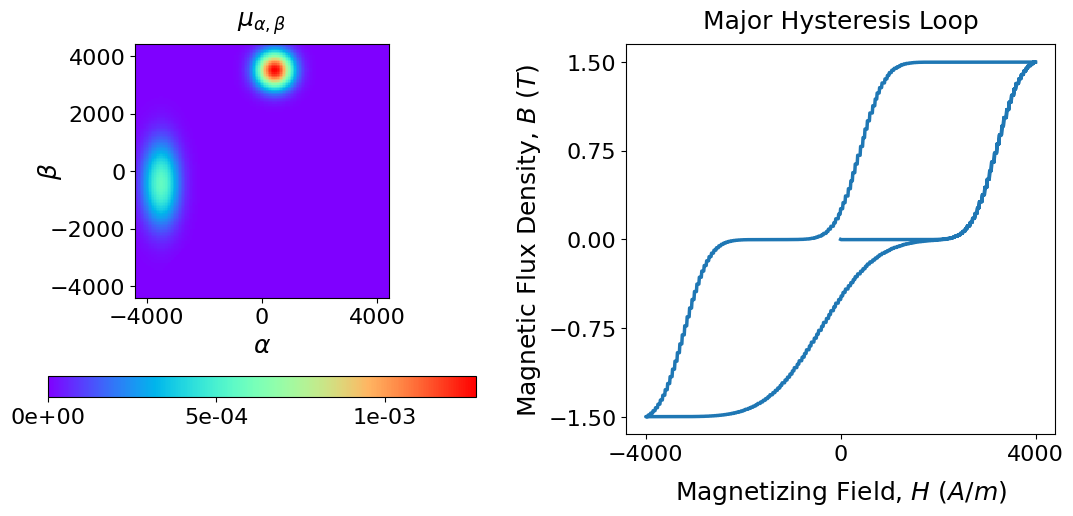

In [11]:
n_grid = int(len(pr_bimodal._grid)**.5)
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_title(r"$\mu_{\alpha, \beta}$", fontsize='18', y=1.04)
axs[1].set_title(r"Major Hysteresis Loop", fontsize='18', y=1.02)
dist = axs[0].imshow(pr_bimodal._density.reshape(n_grid, n_grid).T, cmap='rainbow', **imKwargs)
cbar1 = fig.colorbar(dist, ax=axs[0], location='bottom', orientation="horizontal", format='%.0e', pad=.2)
cbar1.ax.tick_params(labelsize=16)
cbar1.ax.set_xticks([0, 5e-4, 1e-3])
cbar1.ax.xaxis.offsetText.set_fontsize(16)
axs[1].plot(pr_bimodal.H_major, pr_bimodal.B_major,lw=2.5,label=r"Major Loop")
axs[0].set_xlabel(r"$\alpha$",fontsize=18)
axs[0].set_ylabel(r"$\beta$",fontsize=18, labelpad=-10)
axs[1].set_xlabel(r"Magnetizing Field, $H\ (A / m)$", fontsize=18, labelpad=10)
axs[1].set_ylabel(r"Magnetic Flux Density, $B\ (T)$",fontsize=18)
axs[1].axis(1.1*array([pr_bimodal.H_major.min(), pr_bimodal.H_major.max(), pr_bimodal.B_major.min(), pr_bimodal.B_major.max()]))
for ax in axs: 
    ax.tick_params(labelsize=16)
    ax.set_xticks(H_ticks[::2])
axs[0].set_yticks(H_ticks)
axs[1].set_yticks([-1.5, -.75, 0, .75, 1.5])
fig.subplots_adjust(wspace=.35, bottom=.1)
fig.show()

In [12]:
opt_grid = load("pr-model_g20-steel_grid-100.npy")
opt_density = load("pr-model_g20-steel_density-100.npy")

In [13]:
opt_grid.shape

(10000, 2)